<a href="https://colab.research.google.com/github/fle1scha/DL4NTP/blob/main/DL4NTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add all imports and print TensorFlow version to verify it is correct version

In [53]:
import tensorflow as tf
from tensorflow import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import datetime as dt

from datetime import datetime, date
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers  import LSTM
from tensorflow.keras.layers  import TimeDistributed
from tensorflow.keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import array
from numpy import cumsum
from pandas.tseries.holiday import USFederalHolidayCalendar
from random import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

print(keras.__version__)

2.6.0


# Read in Data

1. Mount Google Drive file system

In [54]:
# from google.colab import drive # Hosting the file in Google Drive, need to mount the drive so it is accessible
# # Currently Google forces an authorisation code, local runtime would rectify this
# drive.mount('/content/gdrive', force_remount=True) #force_remount forces Google t

In [55]:
#Read in SANREN dataset.
with open('SANREN_large.txt') as f:
  SANReN = f.readlines()

# ***Data Preprocessing***

In [56]:
#Clean dataframe headers and create labels.
headings_line = SANReN[0].split()

headings_line[4:7] = [''.join(headings_line[4:7])] #Merge 'Src', 'IP', and 'Addr:Port' 
headings_line[5:8] = [''.join(headings_line[5:8])] #Merge 'Dst', 'IP', and 'Addr:Port' 
headings_line = headings_line[0:6] + headings_line[8:13] #Remove 'Flags', 'Tos', and 'Flows'.

print(headings_line)

['Date', 'first-seen', 'Duration', 'Proto', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Packets', 'Bytes', 'pps', 'bps', 'Bpp']


In [86]:
#Clean time-series data points. 
framedata = []
for i in range(1, 4001):
  data_line = SANReN[i].split()

  if ((data_line[11] == "M" or data_line[11] == 'G') and (data_line[14] == 'M' or data_line[14] == 'G')): #Bytes and BPS in megabytes\n"
    #print("1 and 2") 
    if (data_line[11] == 'G'):
      data_line[10] = float(data_line[10])*100000000
    else:
      data_line[10] = float(data_line[10])*1000000\

    if (data_line[14] == 'G'):
      data_line[13] = float(data_line[13])*100000000
    else:
      data_line[13] = float(data_line[13])*1000000
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:14] + data_line[15:16]
     
  elif (data_line[13] == 'M'): #BPS measured in megabytes
    #print("2")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:13] + data_line[14:15]
    data_line[9] = float(data_line[9])*1000000 #Change M bytes into byte measurement. 
  
  elif data_line[11] == 'M': #Bytes measured in megabytes
    #print("1")
    
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:11] + data_line[12:15]
    data_line[7] = float(data_line[7])*1000000 #Change M bytes into byte measurement. 
    
  else: #No megabyte metrics
    #print("0")
    data_line = data_line[0:5] + data_line[6:7] + data_line[9:14]
   

  #data_line  = np.asarray(data_line) #Turn each line into a NumPy array.
  framedata.append(data_line) #append each line to 'mother' array.

In [87]:
#Convert Numpy array into Pandas dataframe.
df = pd.DataFrame(np.array(framedata), columns=headings_line) 
print(df.shape)

(4000, 11)


In [88]:
#Define all data types correctly. 
df['Datetimetemp'] = df['Date'] + 'T' + df['first-seen'] #Combine Date and first-seen
df = df.astype({'Date': 'datetime64[ns]'})
df["Day"] = df['Date'].dt.dayofweek #Created Day variable.
#df['Date'] = df['Date'].map(dt.datetime.toordinal)
df = df.astype({'first-seen': np.datetime64})
df = df.astype({'Duration': np.float64})
df = df.astype({"SrcIPAddr:Port": str})
df = df.astype({"DstIPAddr:Port": str})
df = df.astype({"Packets": np.int64})
df = df.astype({"Bytes": np.float64})
df = df.astype({"pps": np.float64})
df = df.astype({"bps": np.float64})
df = df.astype({"Bpp": np.float64})

#Create binary Weekend variable.
df['Weekend'] = 0
df.loc[df['Day'] == 5 , 'Weekend'] = 1
df.loc[df['Day'] == 6 , 'Weekend'] = 1

#Insert combined Datetime at front of dataframe.
df.insert(0, 'Datetime', df['Datetimetemp'])
df['Datetime'] = df.Datetime.astype('datetime64[ns]')
df['Datetime'] = df.Datetime.astype('int64') #Convert Datetime into an integer representation. This is a deprecated method. 

#Define university holiday calender
holidays = pd.date_range(start='2020-1-1', end='2020-3-14', freq = '1D')
holidays = holidays.append(pd.date_range(start='2020-5-1', end='2020-5-9', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-07-08', end='2020-08-02', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-09-18', end='2020-09-27', freq='1D'))
holidays = holidays.append(pd.date_range(start='2020-11-24', end='2020-12-31', freq='1D'))
print(df['Date'])
#Add Holiday column to dataframe.
df['Holiday'] = 0
df.loc[(df['Date']) == any(holidays.date), 'Holiday'] = 1 #Can't get this to work



ValueError: could not convert string to float: 'G'

In [60]:
#Delete unused columns.
del df['Date']
del df['first-seen']
del df['Datetimetemp']

In [61]:
#One-Hot Encoding
category_df = (df.copy().drop(['Day', 'Weekend', 'Holiday', 'SrcIPAddr:Port', 'DstIPAddr:Port', 'Datetime', 'Duration', 'Packets', 'Bytes', 'pps', 'bps', 'Bpp'], axis = 1))
for x in category_df.columns:
    #Printing unique values per categorical variable
    print(x ,':', len(category_df[x].unique()))

encoder = OneHotEncoder(sparse=False)
#Transform data
onehot = encoder.fit_transform(category_df)
category_df = pd.DataFrame(np.array(onehot))


Proto : 4


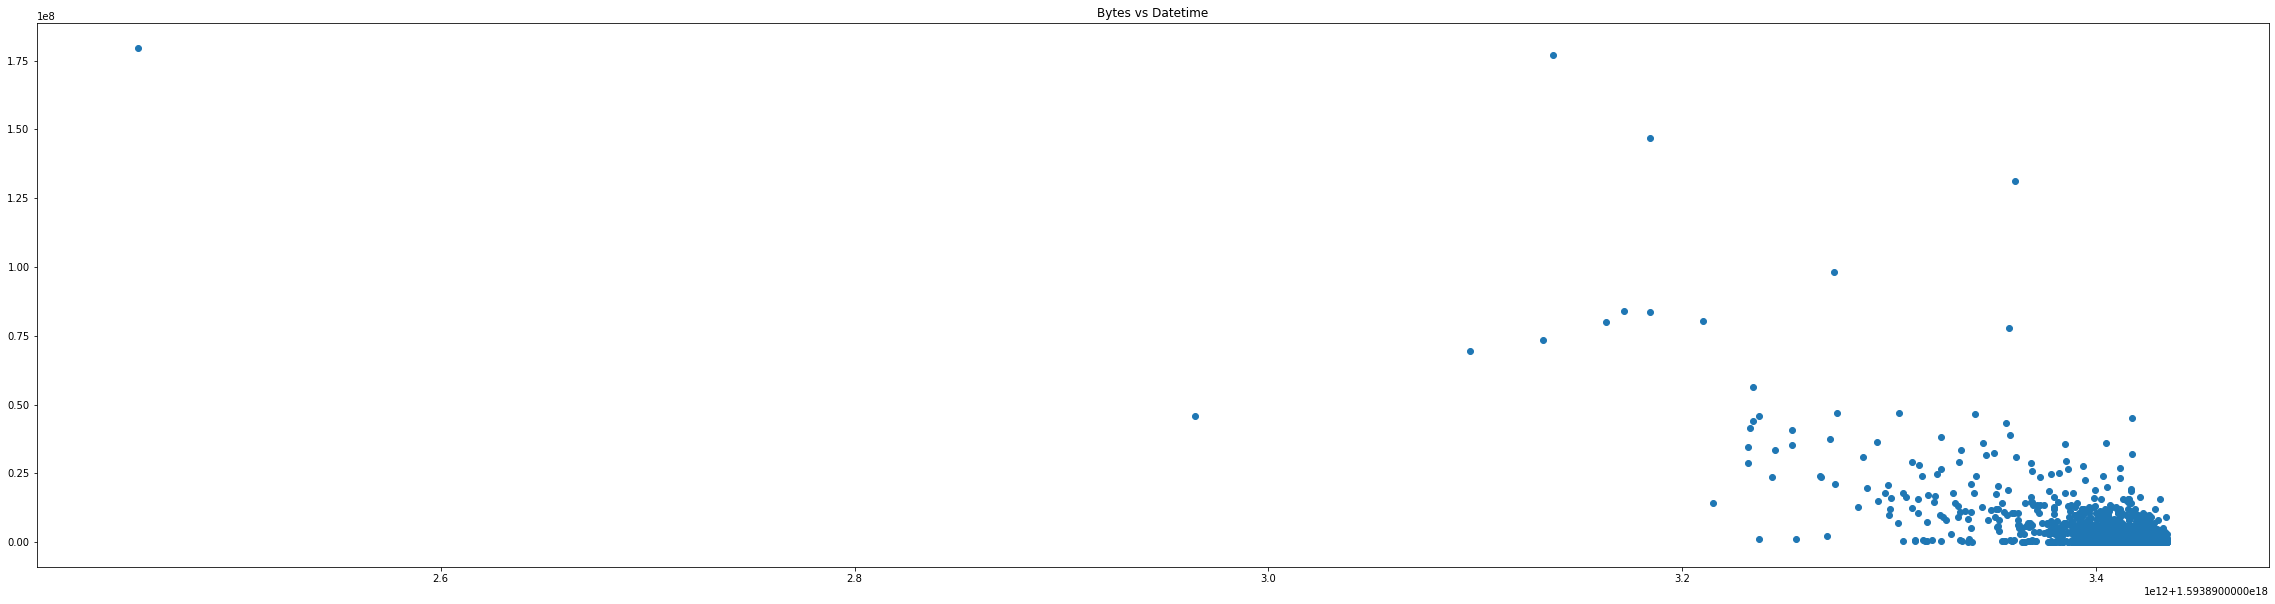

In [62]:
#A plot of Bytes vs Datetime
plt.figure(figsize=(40,10))
plt.title("Bytes vs Datetime")
plt.scatter(df['Datetime'], df['Bytes']) #changed to scatter because line graph is very bunched. fromordinal only differentiates by date so will have to find a way to get it into seconds. 


In [63]:
#Add encoded categorical data to regression data
df = (df.copy().drop(['SrcIPAddr:Port', 'DstIPAddr:Port', 'Proto'], axis = 1)).copy()
print(df.shape)
df = pd.concat([df, category_df], axis = 1)
print(df)

(3000, 10)
                 Datetime  Duration  Packets       Bytes     pps         bps  \
0     1593893406480000000     1.223     4500    234000.0  3679.0   1500000.0   
1     1593893341555000000    78.205    31000  46500000.0   396.0   4800000.0   
2     1593893401690000000     5.307     1000     40000.0   188.0     60297.0   
3     1593893363019000000    43.982     2000   3000000.0    45.0    545677.0   
4     1593893407007000000     0.000      500    750000.0     0.0         0.0   
...                   ...       ...      ...         ...     ...         ...   
2995  1593893434094000000     0.212     1000   1500000.0  4716.0  56600000.0   
2996  1593893434097000000     0.000      500    750000.0     0.0         0.0   
2997  1593893434110000000     0.000      500     68500.0     0.0         0.0   
2998  1593893418962000000    15.981     5000   7500000.0   312.0   3800000.0   
2999  1593893434189000000     2.059     2000   2800000.0   971.0  10900000.0   

         Bpp  Day  Weekend  

In [64]:
#Split data into both training and test set. Use 80/20 split.
test_size = int(len(df) * 0.2) # the test data will be 20% (0.2) of the sample.
train = df.iloc[:-test_size,:].copy()  #Not copying here threw an error. Must be careful not to keep two copies for memory reasons.
test = df.iloc[-test_size:,:].copy() 

X_train = train.drop('Bytes',axis=1).copy() #Drop target variable from training data. 
y_train = train[['Bytes']].copy() # The double brackets are to keep Bytes in a pandas dataframe format, otherwise it will be pandas Series.
print(X_train.shape, y_train.shape) #Check shape of training variables. 

(2400, 13) (2400, 1)


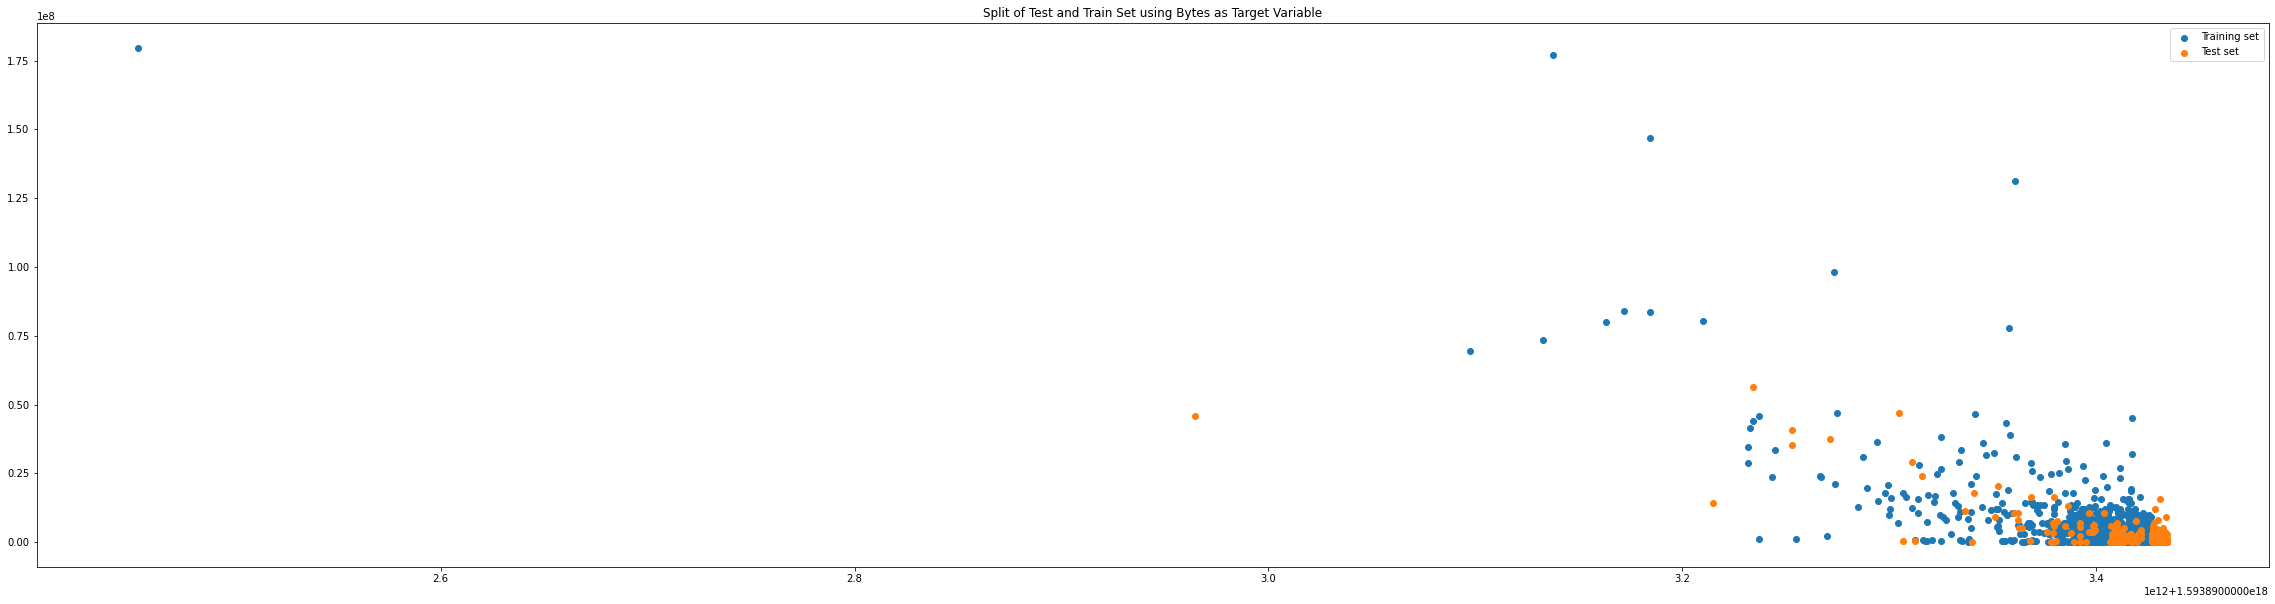

In [65]:
#Visualise split in sample
plt.figure(figsize=(40,10))
plt.title("Split of Test and Train Set using Bytes as Target Variable")
plt.scatter(train['Datetime'],train['Bytes'],label='Training set')
plt.scatter(test['Datetime'],test['Bytes'],label='Test set')
plt.legend()

In [66]:
#Scale training dating
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scikit MinMixScaler allows all variables to be normalised between 0 and 1.
Xscaler.fit(X_train) #Compute the minimum and maximum to be used for later scaling
scaled_X_train = Xscaler.transform(X_train) #Scale features of X according to feature_range.

print(X_train.shape) #X_train shape is the same as earlier but now scaled. 
print(scaled_X_train) #Demonstrate normalised data. 

(2400, 13)
[[9.78617904e-01 1.26059602e-03 3.34728033e-02 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [9.11924050e-01 8.06090854e-02 2.55230126e-01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [9.73697402e-01 5.47014150e-03 4.18410042e-03 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 ...
 [9.99665118e-01 9.48281549e-05 8.36820084e-03 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [9.99668200e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [9.39865102e-01 6.58643380e-02 7.94979079e-02 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]]


In [67]:
#Scale training response
Yscaler = MinMaxScaler(feature_range=(0, 1)) #apply same normalisation to response. 
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

print(scaled_y_train.shape) #Shape is constant. 

(2400,)


In [68]:
#Define input_shape for LSTM
n_input = 100 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 100 # Number of timeseries samples in each batch
train_generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
print(train_generator[0][0].shape)

(100, 100, 13)


# Simple LSTM Implementation

In [69]:
# The sequential argument means that we can add layers without worrying about the underlying shape of the tensors
simple_LSTM_model = Sequential() 
# Model is an LSTM, 50 is dimentionality of the output, activation function is relu
simple_LSTM_model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features))) 
# Dense layer as the first layer of the model
simple_LSTM_model.add(Dense(1)) 
# Compile the model with the adam optimizer, loss measured in Mean Squarred Error
# Adam refers to the learning rate change, which is measured by the exponentially decaying average of past gradients
simple_LSTM_model.compile(optimizer='adam', loss='mse') 
# Print out a summary of the LSTM to check that it was compiled correctly 
simple_LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
23/23 [==============================] - 4s 61ms/step - loss: 0.0031
Epoch 2/20
23/23 [==============================] - 2s 78ms/step - loss: 0.0024
Epoch 3/20
23/23 [==============================] - 2s 66ms/step - loss: 0.0022
Epoch 4/20
23/23 [==============================] - 1s 57ms/step - loss: 0.0021
Epoch 5/20
23/23 [==============================] - 1s 47ms/step - loss: 0.0019
Epoch 6/20
23/23 [==============================] - 1s 55ms/step - loss: 0.0017
Epoch 7/20
23/23 [==============================] - 1s 50ms/step - loss: 0.0014
Epoch 8/20
23/23 [==============================] - 1s 50ms/step - loss: 0.0012
Epoch 9/20
23/23 [==============================] - 1s 49ms/step - loss: 9.2748e-04
Epoch 10/20
23/23 [==============================] - 1s 60ms/step - loss: 9.8245e-04
Epoch 11/20
23/23 [==============================] - 2s 72ms/step - loss: 7.6559e-04
Epoch 12/20
23/23 [==============================] - 1s 51ms/step - loss: 5.2521e-04
Epoch 13/20
23/23 [==

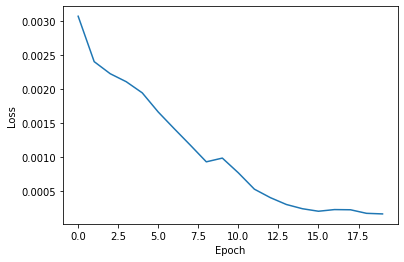

In [70]:
#Fit the data to the model and train.
simple_LSTM_model.fit(train_generator, epochs=20, verbose = 1) # Fit the features excluding target, and predict the target value
# verbose of 0 hides the training, 2 shows the full log
loss_per_epoch = simple_LSTM_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [71]:
#Testing x data
X_test = test.drop('Bytes', axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=100, batch_size=b_size) #There are only 17 samples in the test set so it cannot look back.
print(test_generator[0][0].shape)

(100, 100, 13)


        y_true        y_pred
0     750000.0  7.475538e+06
1      60000.0  4.600451e+05
2     823000.0  8.665039e+05
3     105500.0  4.125563e+05
4     750000.0 -9.372708e+05
..         ...           ...
495  1500000.0 -1.736116e+06
496   750000.0  9.689681e+05
497    68500.0  9.630977e+05
498  7500000.0 -1.337659e+06
499  2800000.0  6.170313e+06

[500 rows x 2 columns]


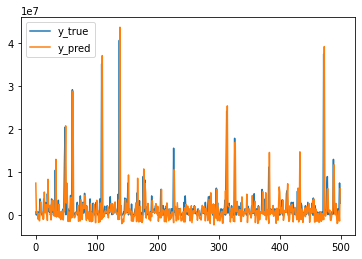

In [72]:
#Predicted LSTM response for bytes
y_pred_scaled = simple_LSTM_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
simple_lstm_results.plot()
print(simple_lstm_results)

In [73]:
#Predicted  LSTM response in megabytes
simple_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:]/1000000,'y_pred':y_pred.ravel()/1000000})
simple_lstm_results['residuals'] = np.square(
    simple_lstm_results.y_pred - simple_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
simple_LSTM_mse = simple_lstm_results.residuals.sum() * (1/len(simple_lstm_results))
print('MSE: ' + str(np.round(simple_LSTM_mse, 3)))

MSE: 33.956


In [74]:
# LSTM Coefficient of Determination Measurement
simple_LSTM_correlation_matrix = np.corrcoef(simple_lstm_results.y_pred,
                          simple_lstm_results.y_true)
corr = simple_LSTM_correlation_matrix[0, 1]
simple_LSTM_R_sq = corr**2
print(np.round(simple_LSTM_R_sq, 5))


0.0


# Bidirectional LSTM Implementation

In [75]:
# Bidirectional LSTM supported in Keras using a layer wrapper 
# Common approach is to use concatenate, providing 2x outputs to next layer
# Takes the first LSTM layer as an argument
# The sequential argument means that we can add layers without worrying about the underlying shape of the tensors
bidirectional_lstm_model = Sequential() 
bidirectional_lstm_model.add(Bidirectional(LSTM(50, return_sequences=False, activation="relu"), input_shape=(n_input, n_features)))
bidirectional_lstm_model.add(Dense(1))
bidirectional_lstm_model.compile(loss='mse', optimizer='adam')
bidirectional_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               25600     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 25,701
Trainable params: 25,701
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
23/23 - 5s - loss: 0.0055
Epoch 2/20
23/23 - 1s - loss: 0.0029
Epoch 3/20
23/23 - 1s - loss: 0.0025
Epoch 4/20
23/23 - 1s - loss: 0.0023
Epoch 5/20
23/23 - 1s - loss: 0.0022
Epoch 6/20
23/23 - 1s - loss: 0.0020
Epoch 7/20
23/23 - 1s - loss: 0.0019
Epoch 8/20
23/23 - 1s - loss: 0.0017
Epoch 9/20
23/23 - 1s - loss: 0.0015
Epoch 10/20
23/23 - 2s - loss: 20354508800.0000
Epoch 11/20
23/23 - 2s - loss: 0.1855
Epoch 12/20
23/23 - 1s - loss: 0.2304
Epoch 13/20
23/23 - 1s - loss: 0.1988
Epoch 14/20
23/23 - 1s - loss: 3.7809
Epoch 15/20
23/23 - 1s - loss: 0.1542
Epoch 16/20
23/23 - 1s - loss: 0.1550
Epoch 17/20
23/23 - 1s - loss: 0.1523
Epoch 18/20
23/23 - 1s - loss: 0.1495
Epoch 19/20
23/23 - 2s - loss: 0.1468
Epoch 20/20
23/23 - 3s - loss: 0.1441


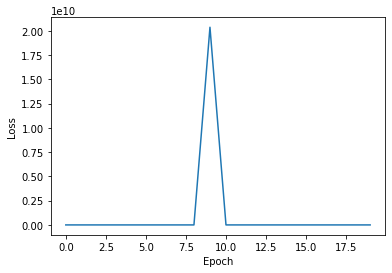

In [76]:
bidirectional_lstm_model.fit(train_generator, epochs=20, verbose=2)
loss_per_epoch = bidirectional_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

        y_true      y_pred
0     750000.0 -69430032.0
1      60000.0 -66787620.0
2     823000.0 -72511440.0
3     105500.0 -69583888.0
4     750000.0 -75891040.0
..         ...         ...
495  1500000.0 -57596968.0
496   750000.0 -50370064.0
497    68500.0 -50589044.0
498  7500000.0 -67503352.0
499  2800000.0 -63910652.0

[500 rows x 2 columns]


<AxesSubplot:>

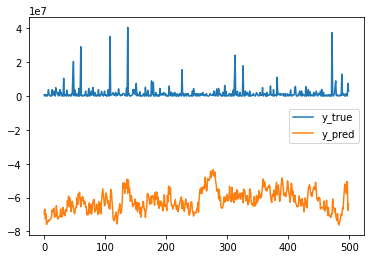

In [77]:
y_pred_scaled = bidirectional_lstm_model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:],'y_pred':y_pred.ravel()})
print(bidirectional_lstm_results)
bidirectional_lstm_results.plot()

Predictions made in megabytes

In [78]:
bidirectional_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:]/1000000,'y_pred':y_pred.ravel()/1000000})
bidirectional_lstm_results['residuals'] = np.square(bidirectional_lstm_results.y_pred - bidirectional_lstm_results.y_true)
# results['residuals_squared'] = np.square(results.residuals)
bidirectional_LSTM_mse = bidirectional_lstm_results.residuals.sum() * (1/len(bidirectional_lstm_results))
print('MSE: ' + str(np.round(bidirectional_LSTM_mse, 3)))

MSE: 4107.925


In [79]:
# LSTM Coefficient of Determination Measurement
bidirectional_LSTM_correlation_matrix = np.corrcoef(bidirectional_lstm_results.y_pred,
                                                    bidirectional_lstm_results.y_true)
corr = bidirectional_LSTM_correlation_matrix[0, 1]
bidirectional_LSTM_R_sq = corr**2
print(np.round(bidirectional_LSTM_R_sq, 5))

0.00287


# Stacked LSTM Implementation

In [80]:
stacked_lstm_model = Sequential() # The sequential argument means that we can add layers without worrying about the underlying shape of the tensors 
stacked_lstm_model.add(LSTM(50, return_sequences=True, activation="relu", input_shape=(n_input, n_features)))
stacked_lstm_model.add(LSTM(50, return_sequences=True))
stacked_lstm_model.add(LSTM(50))
stacked_lstm_model.add(Dense(1))
stacked_lstm_model.compile(loss='mse', optimizer='adam')
stacked_lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           12800     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
23/23 - 11s - loss: 0.0028
Epoch 2/20
23/23 - 6s - loss: 0.0025
Epoch 3/20
23/23 - 11s - loss: 0.0025
Epoch 4/20
23/23 - 10s - loss: 0.0026
Epoch 5/20
23/23 - 4s - loss: 0.0026
Epoch 6/20
23/23 - 5s - loss: 0.0025
Epoch 7/20
23/23 - 6s - loss: 0.0025
Epoch 8/20
23/23 - 5s - loss: 0.0025
Epoch 9/20
23/23 - 5s - loss: 0.0025
Epoch 10/20
23/23 - 5s - loss: 0.0025
Epoch 11/20
23/23 - 5s - loss: 0.0025
Epoch 12/20
23/23 - 5s - loss: 0.0025
Epoch 13/20
23/23 - 4s - loss: 0.0024
Epoch 14/20
23/23 - 5s - loss: 0.0024
Epoch 15/20
23/23 - 4s - loss: 0.0023
Epoch 16/20
23/23 - 5s - loss: 0.0022
Epoch 17/20
23/23 - 5s - loss: 0.0022
Epoch 18/20
23/23 - 5s - loss: 0.0019
Epoch 19/20
23/23 - 5s - loss: 0.0013
Epoch 20/20
23/23 - 6s - loss: 5.7936e-04


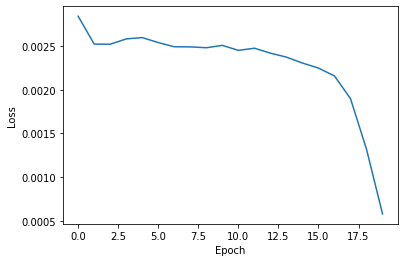

In [81]:
stacked_lstm_model.fit(train_generator, epochs=20, verbose=2)
loss_per_epoch = stacked_lstm_model.history.history['loss']
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

[[ 3.22250910e-02]
 [ 2.10246891e-02]
 [ 3.75574082e-03]
 [ 3.93907866e-03]
 [-3.54809733e-03]
 [ 9.32760723e-03]
 [-2.08133645e-03]
 [ 1.00651570e-02]
 [ 1.75633878e-02]
 [ 1.16844354e-02]
 [ 4.54474799e-03]
 [-8.97086784e-03]
 [-1.00673279e-02]
 [-6.67247782e-03]
 [ 2.85450071e-02]
 [ 1.76704284e-02]
 [ 1.39798597e-02]
 [ 5.29470854e-03]
 [ 6.42801449e-03]
 [-8.79216753e-03]
 [ 3.43468972e-02]
 [ 1.38612092e-02]
 [ 7.25301728e-03]
 [ 6.48226961e-03]
 [ 1.04213543e-02]
 [-7.56625319e-03]
 [ 6.36843732e-03]
 [ 5.81482705e-03]
 [ 8.23355559e-03]
 [ 1.62906982e-02]
 [-2.50164815e-03]
 [ 6.54533133e-03]
 [-4.39777318e-03]
 [ 5.60377613e-02]
 [ 1.69961024e-02]
 [ 1.61915626e-02]
 [ 1.01025328e-02]
 [-5.40403835e-03]
 [ 1.21569540e-02]
 [-1.29732967e-03]
 [ 4.74554999e-03]
 [-6.11155899e-03]
 [ 8.73837899e-03]
 [ 1.09579237e-02]
 [-2.58737197e-03]
 [-5.03794570e-03]
 [ 1.41758909e-02]
 [ 1.47780050e-02]
 [ 3.62501033e-02]
 [ 8.84852707e-02]
 [ 2.47905236e-02]
 [ 2.78334841e-02]
 [ 1.9896511

<AxesSubplot:>

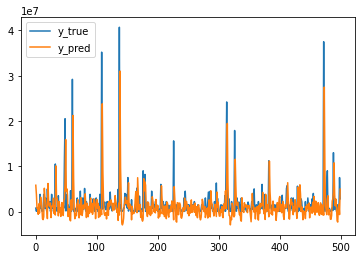

In [82]:
y_pred_scaled = stacked_lstm_model.predict(test_generator)
print(y_pred_scaled)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
stacked_lstm_results = pd.DataFrame({'y_true':test['Bytes'].values[100:], 'y_pred':y_pred.ravel()})
print(stacked_lstm_results)
stacked_lstm_results.plot()


Predictions made in megabytes

In [83]:
stacked_lstm_results = pd.DataFrame(
    {'y_true': test['Bytes'].values[100:]/1000000, 'y_pred': y_pred.ravel()/1000000})
stacked_lstm_results['residuals'] = np.square(
    stacked_lstm_results.y_pred - stacked_lstm_results.y_true)
stacked_LSTM_mse = stacked_lstm_results.residuals.sum() * \
    (1/len(stacked_lstm_results))
print('MSE: ' + str(np.round(stacked_LSTM_mse, 3)))

MSE: 26.692


In [84]:
# LSTM Coefficient of Determination Measurement
simple_LSTM_correlation_matrix = np.corrcoef(simple_lstm_results.y_pred,
                          simple_lstm_results.y_true)
corr = simple_LSTM_correlation_matrix[0, 1]
simple_LSTM_R_sq = corr**2
print(np.round(simple_LSTM_R_sq, 5))

# LSTM Coefficient of Determination Measurement
bidirectional_LSTM_correlation_matrix = np.corrcoef(bidirectional_lstm_results.y_pred,
                                                    bidirectional_lstm_results.y_true)
corr = bidirectional_LSTM_correlation_matrix[0, 1]
bidirectional_LSTM_R_sq = corr**2
print(np.round(bidirectional_LSTM_R_sq, 5))

# LSTM Coefficient of Determination Measurement
stacked_LSTM_correlation_matrix = np.corrcoef(stacked_lstm_results.y_pred,
                                                    stacked_lstm_results.y_true)
corr = stacked_LSTM_correlation_matrix[0, 1]
stacked_LSTM_R_sq = corr**2
print(np.round(stacked_LSTM_R_sq, 5))

0.0
0.00287
0.00041


In [85]:
print('Mean Squared Errors on Test Sets in MB')
print('Bidirectional LSTM MSE: ' + str(np.round(bidirectional_LSTM_mse, 3)))
print('Simple LSTM MSE: ' + str(np.round(simple_LSTM_mse, 3)))
print('Stacked LSTM MSE: ' + str(np.round(stacked_LSTM_mse, 3)))

Mean Squared Errors on Test Sets in MB
Bidirectional LSTM MSE: 4107.925
Simple LSTM MSE: 33.956
Stacked LSTM MSE: 26.692


Coefficient of Determination = R^2
- Regression error metric, evaluate the accuracy and efficiency of a model
- Describes the variation in response or target variable which is predicted by independent variables of the data model